In [70]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import collections
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from cool_image_functions import *
%matplotlib inline

In [71]:
# Do only once and store the result
caliberate_camera()

(array([[  1.15777818e+03,   0.00000000e+00,   6.67113857e+02],
        [  0.00000000e+00,   1.15282217e+03,   3.86124583e+02],
        [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]]),
 array([[-0.24688507, -0.02373156, -0.00109831,  0.00035107, -0.00259866]]))

In [184]:
image_count = 0
prev_left_fitx = 0
prev_right_fitx = 0
prev_ploty = 0

similarity_theta = 8*100000
average_buffer_size = 80
min_avg_gap = 40*10000
global left_fitx_buffer, right_fitx_buffer, ploty_buffer 
left_fitx_buffer = collections.deque(maxlen=average_buffer_size)
right_fitx_buffer = collections.deque(maxlen=average_buffer_size)
ploty_buffer = collections.deque(maxlen=average_buffer_size)

def processing_pipeline(current_image):
    
    global prev_left_fitx, prev_right_fitx, prev_ploty, image_count
    image_count = image_count + 1
    
    
    # load the caliberation result and use for undistorting any imag
    dist_pickle = pickle.load( open( "camera_cal/mtx_dist_pickle.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    
    # undistort
    img = current_image
    image_shape = img.shape
    undistorted_img = cal_undistort(img, mtx, dist)
    
    #color_binary to check the individual contributions of x_gradient and color channel
    processed_image, color_binary = apply_color_and_gradient_threshold(undistorted_img, (170, 255), (35, 100))
    
    # Perform Masking
    points = np.array([[(0,image_shape[0]),(550, 470), (700, 470), (image_shape[1],image_shape[0])]], dtype=np.int32)
    masked_image = mask_this_image(processed_image, points)
    
    # Warping: Perspective Transformation
    src = np.float32(
    [[120, 720],
     [550, 470],
     [700, 470],
     [1160, 720]])

    dst = np.float32(
    [[200,720],
     [200,0],
     [1080,0],
     [1080,720]])
    warped_image, Minv = transform_perspective(src, dst, masked_image, image_shape)
    
    # Fit a polynomial on lane lines
    leftx, lefty, rightx, righty, out_img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds   = extract_pixel_positions(warped_image)
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if image_count > 1:
        max_gap = np.max(np.abs(right_fitx - left_fitx))
        min_gap = np.min(np.abs(right_fitx - left_fitx))
        #print (max_gap, min_gap)
        if ( (sum(np.abs(right_fitx - prev_right_fitx))) > similarity_theta ) or (min_gap < 100):
            left_fitx = prev_left_fitx
            right_fitx  = prev_right_fitx
            ploty = prev_ploty
    ploty_buffer.append(ploty)
    left_fitx_buffer.append(left_fitx)
    right_fitx_buffer.append(right_fitx)
    
    avg_ploty = sum(ploty_buffer) / min(image_count,average_buffer_size)
    avg_left_fitx = sum(left_fitx_buffer) / min(image_count,average_buffer_size)
    avg_right_fitx = sum(right_fitx_buffer) / min(image_count,average_buffer_size)
    
    # Determine curvature of the lane
    y_eval = 500

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters

    curvature = (left_curverad + right_curverad) / 2
    centre = center(719, left_fit, right_fit)
    
    # Plot result on the road
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([avg_left_fitx, avg_ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([avg_right_fitx, avg_ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image_shape[1], image_shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
    
    # Write curvature on the image
    write_data_on_image(result, curvature=curvature, left_curvature=left_curverad,  right_curvature=right_curverad, vehicle_position=centre)
    
    prev_left_fitx = left_fitx
    prev_right_fitx = right_fitx
    prev_ploty = ploty
    
    return result
    

10493.1678552 743.276846211


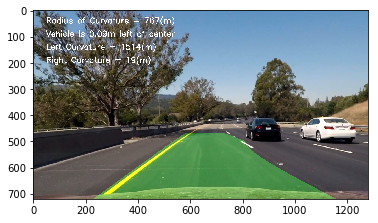

In [183]:
plt.imshow(processing_pipeline(mpimg.imread('test_images/test6.jpg')))

In [185]:
output = 'project_output_colour.mp4'
input_clip = VideoFileClip("project_video.mp4")
output_clip = input_clip.fl_image(processing_pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_output_colour.mp4
[MoviePy] Writing video project_output_colour.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [13:49<00:00,  1.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_colour.mp4 

Wall time: 13min 54s
